<a href="https://colab.research.google.com/github/vineet-codes/defi-exploration/blob/main/test_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import random
from collections import defaultdict

In [3]:
def get_usernames(r=2):
  inputstring = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabscdefghijklmnopqrstuvwxyz0123456789'
  # print(len(inputstring))
  # username_list =list(set([inputstring[x:y] for x, y in itertools.combinations(range(len(inputstring) + 1), r = r)]))
  username_list = ['Harsh', 'Jennifer', 'Gary', 'Joe', 'Anubhav', 'Alan', 'Vineet', 'Dave', 'Anar', 'Wei', 'Brain', 'Barry', 'Danny', 'John', 'Michal',
                   'Tom', 'Blake', 'Asa', 'Georgie', 'Harry']
  return username_list

len(get_usernames())

20

In [15]:
class Vault:

  def __init__(self, name):
    # pool is of the form {user: [(amount_1, tick_1), (amount_2, tick_2)]}
    self.pool = {}

    self.name = name
    # self.rewards_pool = rewards_pool
    # tick is used for having a contcept of time in our analysis
    self.tick = 0

  def update_tick(self, step):
    self.tick += step

  def balanceOf(self, user):
    user_txns = self.pool.get(user,[])
    if(len(user_txns) == 0):
      return 0 #f'It seems {user} has made no txns in to the Vault'
    return sum([amount for (amount, _) in user_txns])
    

  def shareOfUser(self, user):
    """
    return: users shares of the total pool
    """
    return self.balanceOf(user) / self.tvl()

  def deposit(self, amount, user):
    """
    return: tuple (user, updated balance)
    """
    if (user in self.pool.keys()):
      user_txns = self.pool.get(user, []) 
      user_txns.append((amount, self.tick))
      self.pool[user] = user_txns
    else:
      self.pool[user] = [(amount, self.tick)]
    return user, self.pool[user]

  def withdraw(self, withdraw_amount, user):
    """
    return: tuple (user, updated balance)
    """
    if(user not in self.pool.keys()):
      return f'{user} has not deposited in the vault'
    
    if(self.balanceOf(user) < withdraw_amount):
      return f'Not enough balance, {user} can one withdraw upto: {self.balanceOf(user)}'
    
    # db update
    # self.pool[user] = self.pool[user] - withdraw_amount
    self.pool[user].append((-1* withdraw_amount, self.tick))

    return user,self.balanceOf(user)

  def tvl(self):
    result = 0
    for user, txns in self.pool.items():
      user_balance = self.balanceOf(user)
      result += user_balance
    return result
      
    return sum([v for _,v in self.pool.items()])
  
  def get_pool(self):
    return self.pool



class Stakes:

  def __init__(self, name="YOP_LOCKBOX"):

    # pool is of the form {user: [(amount_1, duration_1, tick_1), (amount_2, duration_2, tick_2), (amount_1, duration_1, tick_2)]}
    self.pool = {}

    self.name = name
    # self.rewards_pool = rewards_pool
    # tick helps with time travel
    self.tick = 0

  def update_tick(self, step):
    self.tick += step

  def stake(self, user, amount, duration):
    """
    duratrion: in months
    """
    # assert self.tick == tick

    user_stakes = self.pool.get(user, [])
    # print(user_stakes)
    user_stakes.append((amount, duration, self.tick))
    self.pool[user] = user_stakes
    # self.rewards_pool.tick()
    return user, self.pool.get(user, [])

  def unstake(self):
    pass


  def get_pool(self):
    return self.pool

  def pool_size(self):
    return sum([amount*duration for user in self.pool.keys() for amount, duration, _ in self.pool[user]])

  def shareOfUser(self, user):
    totalPoolSize = self.pool_size()
    if(totalPoolSize == 0):
      return 0
    userPoolSize = sum([amount*duration for amount, duration, _ in self.pool.get(user, [(0,0,0)])])
    return userPoolSize / totalPoolSize



class Rewards:

  def __init__(self, vault, stakes, 
               weights=[0.2,0.8], 
               vault_stake_reward_split = [0.75, 0.25], 
               yearly_emissions = 3891931,
               yop_token_price = 1):
    
    self.tick = 0
    
    self.yearly_emissions = yearly_emissions

    self.vault = vault
    self.stakes = stakes

    self.weights = weights
    self.vault_stake_reward_split = vault_stake_reward_split
    self.yop_token_price = yop_token_price

    # list to store history state per tick
    self.reward_per_tick_history = []

  
  def update_tick(self, step):
    self.tick += step


  def calculate_rewards(self):

    result = {}
    
    total_power = 0
    for user in list(set(self.vault.pool.keys())):
      vault_boost_multiplier = self.weights[0]*self.vault.shareOfUser(user) + self.weights[1]*self.stakes.shareOfUser(user)
      total_power += vault_boost_multiplier * self.vault.balanceOf(user)

    # print(total_power)

    for user in list(set(self.vault.pool.keys())):
      # print("=========")
      vault_boost_multiplier = self.weights[0]*self.vault.shareOfUser(user) + self.weights[1]*self.stakes.shareOfUser(user)
      # print(f'{user} vault boost multiplier is: {vault_boost_multiplier}')
      # x = (vault_boost_multiplier * self.vault.balanceOf(user) / total_power) * ((self.vault_stake_reward_split[0]/4)*self.yearly_emissions) * (self.yop_token_price)
      x = ((vault_boost_multiplier * self.vault.balanceOf(user)) / total_power) * ((0.2)*self.yearly_emissions) * (self.yop_token_price)
      # print(f"{user} is getting {(x / self.vault.balanceOf(user))*100}% APY in the vault")
      result[user] = (x / self.vault.balanceOf(user))*100
    return result
 
    
  
  def tick_fn(self, step):


    # update clocks for everyone
    self.update_tick(step)
    self.vault.update_tick(step)
    self.stakes.update_tick(step)

    # TODO: calculate the rewards earned in this tick

    # TODO: unstake and calculate stake rewards to be persisted

    # calculate the current vault reward state to be persisted
    state = {}

    # print(f"===Tick: {self.tick}====")
    # print(self.calculate_rewards())
    # print("Vault pool",self.vault.pool)
    # print("Stake Pool", self.stakes.pool)

    state[f'apys_{self.tick}'] = self.calculate_rewards()

    # balance for user at this tick
    state['vault_pool'] = self.vault.pool.copy()

    users = self.vault.pool.keys()
    user_balances = defaultdict()
    for user in users: 
      user_balances[user] = self.vault.shareOfUser(user)

    state['vault_balances'] = user_balances

    state['stake_pool'] = self.stakes.pool.copy()


    users = self.stakes.pool.keys()
    user_balances = defaultdict()
    for user in users: 
      user_balances[user] = self.stakes.shareOfUser(user)
    state['stake_poolShares'] = user_balances

    state['tvl'] = self.vault.tvl()
    state['stake_poolSize'] = self.stakes.pool_size()

    self.reward_per_tick_history.append(state)
    # print("========")

    
    
      

  


# v = Vault()
# print(v.tvl())
# print(v.balanceOf('dfg'))
# v.deposit(5000, 'e')
# print(v.tvl())

class User:

  def __init__(self, name):
    self.name = name

  def __repr__(self):
    return f'{self.name}'

  def vault_rewards(self):
    pass

  def stake_rewards(self):
    pass

In [16]:
def setup_sim(steps=900):

  actions = ['deposit', 'withdraw', 'stake', 'unstake']

  # instantiate vaults and staking pool
  usdc_vault = Vault('USDC_GENESIS')
  yop_stakes = Stakes()
  rewards = Rewards(usdc_vault, yop_stakes)

  action_history = []

  # generate random users from population of all users
  usernames = get_usernames()
  user_population = [User(username) for username in usernames]

  for tick in range(1, steps+1):
    # update the tick
    rewards.tick_fn(1)
    # for each tick
    #  pick a random user and a random action he takes
    user = random.choice(user_population[:20])
    action_name = random.choice(actions[:2])

    # print(f"{user} {action_name}'s at tick {rewards.tick}")
    action_history.append({user: action_name, 'tick': rewards.tick})

    # execute the action
    if(action_name == 'deposit'):
      # deposit: user deposits a random amount in vault
      usdc_vault.deposit(100000, user)
    elif (action_name == 'withdraw'):
      balance = usdc_vault.balanceOf(user)
      usdc_vault.withdraw(balance/2, user)
    elif (action_name == 'stake'):
      yop_stakes.stake(user, 1000, 12)
    else:
      # unstake
      pass

    for user in user_population:
      yop_stakes.stake(user, 1000, 12)
  # print(rewards.calculate_rewards())
  return rewards, user_population, action_history

In [17]:
# rewards, user_population, action_history = setup_sim()

In [18]:
def get_vault_balance(txns):
  return sum([amount for amount, _ in txns])

def get_stats_per_tick(rewards, user_population):
  result = defaultdict(dict)

  # intialize to empty dict
  for user in user_population:
    result[user] = {'apys': [], 'vault_balance': [], 'stake_poolShares':[]}

  for i, tick_history in enumerate(rewards.reward_per_tick_history):
    # print(i)
    for user in user_population:
      result[user]['apys'].append(tick_history[f'apys_{i+1}'].get(user, 0))
      
      user_balance = tick_history['vault_balances'].get(user, 0)
      result[user]['vault_balance'].append(user_balance)

      stake_userbalance = tick_history['stake_poolShares'].get(user, 0)
      result[user]['stake_poolShares'].append(stake_userbalance)

  return result


# result = get_stats_per_tick(rewards, user_population)

In [19]:
# len(user_population)

In [20]:
def plot_results(result, user_population):
  fig, ax = plt.subplots(20,2, figsize=(20,80))
  axes = ax.flatten()

  i = 0
  for user_idx in range(len(user_population)):

    user_apys = result[user_population[user_idx]]['apys']
    user_vault_pool_shares = result[user_population[user_idx]]['vault_balance']
    user_stake_pool_shares = result[user_population[user_idx]]['stake_poolShares']

    axes[i].plot(user_apys, 'b-')
    axes[i].set_ylabel('vault apy', color="b")
    axes_2 = axes[i].twinx()
    axes_2.set_ylim([0,0.9])
    axes[i].set_title(f'{user_population[user_idx]} Vault')
    axes_2.plot(user_vault_pool_shares, 'g-')
    axes_2.set_ylabel(f'{user_population[user_idx]} vault pool share', color="g")

    axes[i+1].plot(user_apys, 'b-')
    axes[i+1].set_ylabel('vault apy', color="b")
    axes[i+1].set_title(f'{user_population[user_idx]} Stake')
    axes_2 = axes[i+1].twinx()
    axes_2.set_ylim([0,0.5])
    axes_2.plot(user_stake_pool_shares, 'm-')
    axes_2.set_ylabel(f'{user_population[user_idx]} staking pool share', color="m")

    i = i + 2

# plot_results(result, user_population)

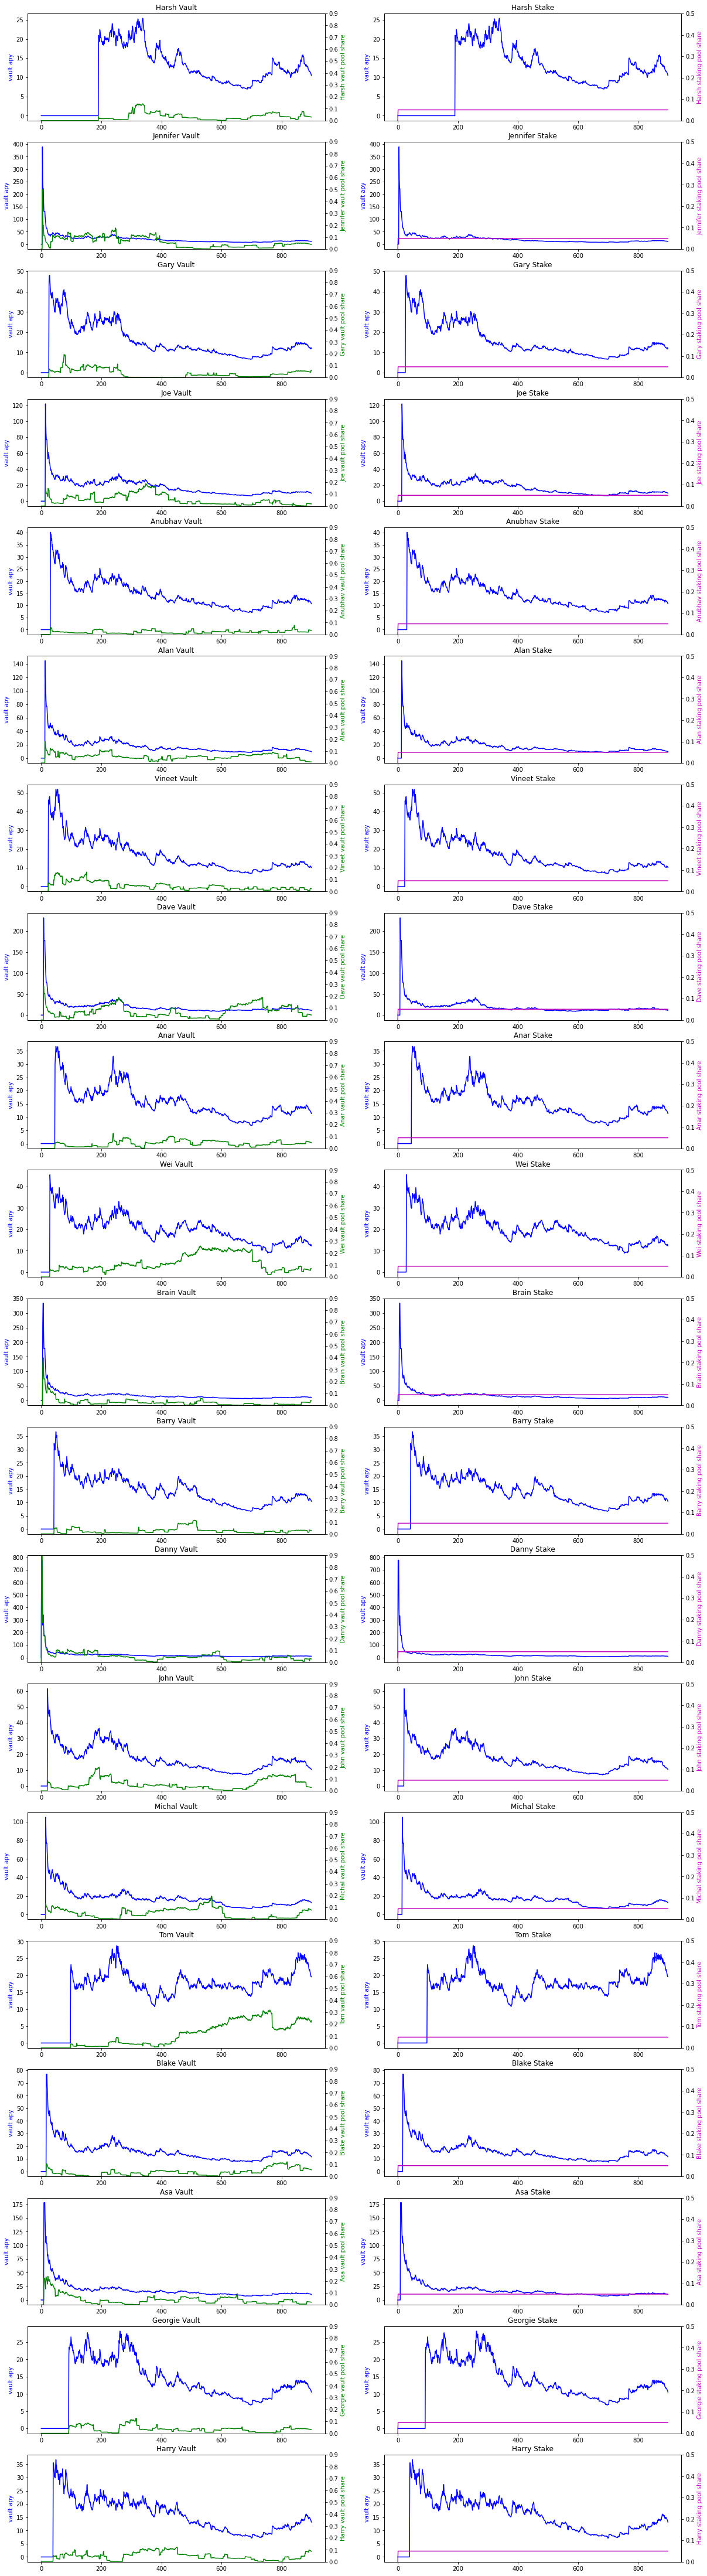

In [21]:
rewards, user_population, action_history = setup_sim()
result = get_stats_per_tick(rewards, user_population)
plot_results(result, user_population)

In [22]:
# user increases his vault share
user = user_population[-1]
for i in range(30):
  rewards.vault.deposit(1000000, user)
  rewards.tick_fn(1)

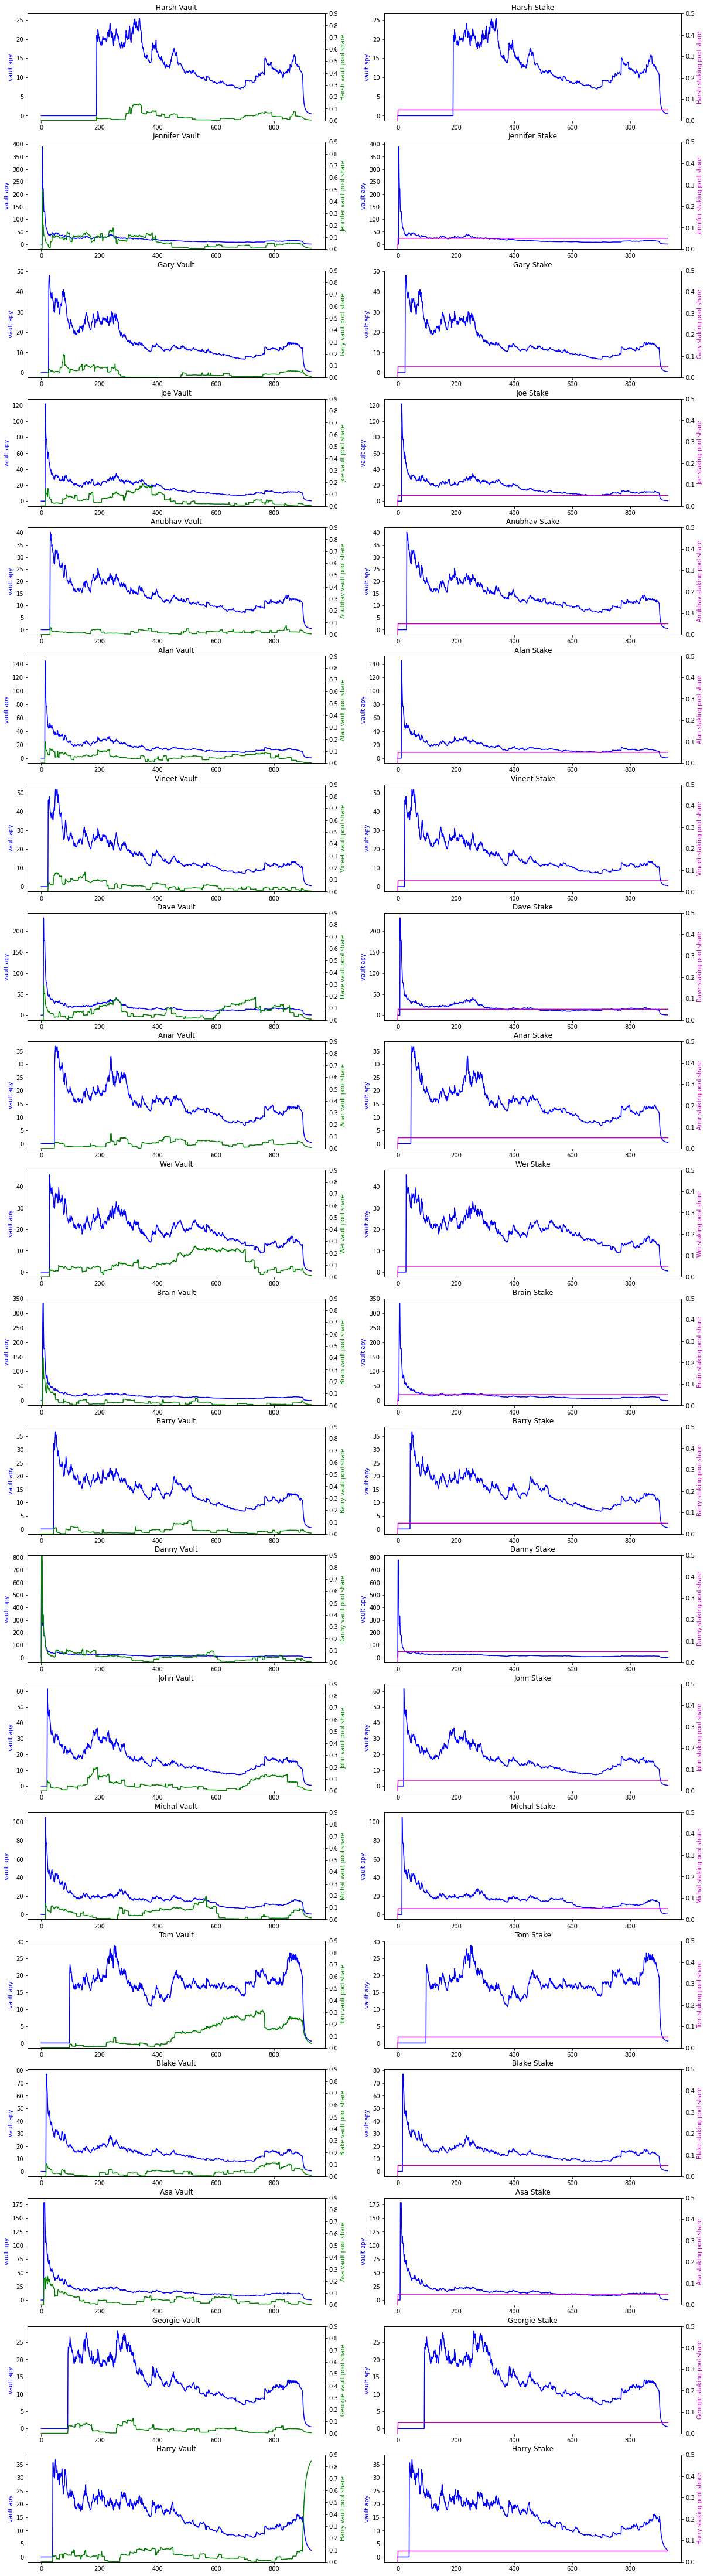

In [23]:
result = get_stats_per_tick(rewards, user_population)
plot_results(result, user_population)

What happens if same user starts increasing his staking pool share ? 

In [28]:
# user increases his vault share
user = user_population[-1]
for i in range(50):
  rewards.stakes.stake(user, 90000, 34)
  rewards.tick_fn(1)

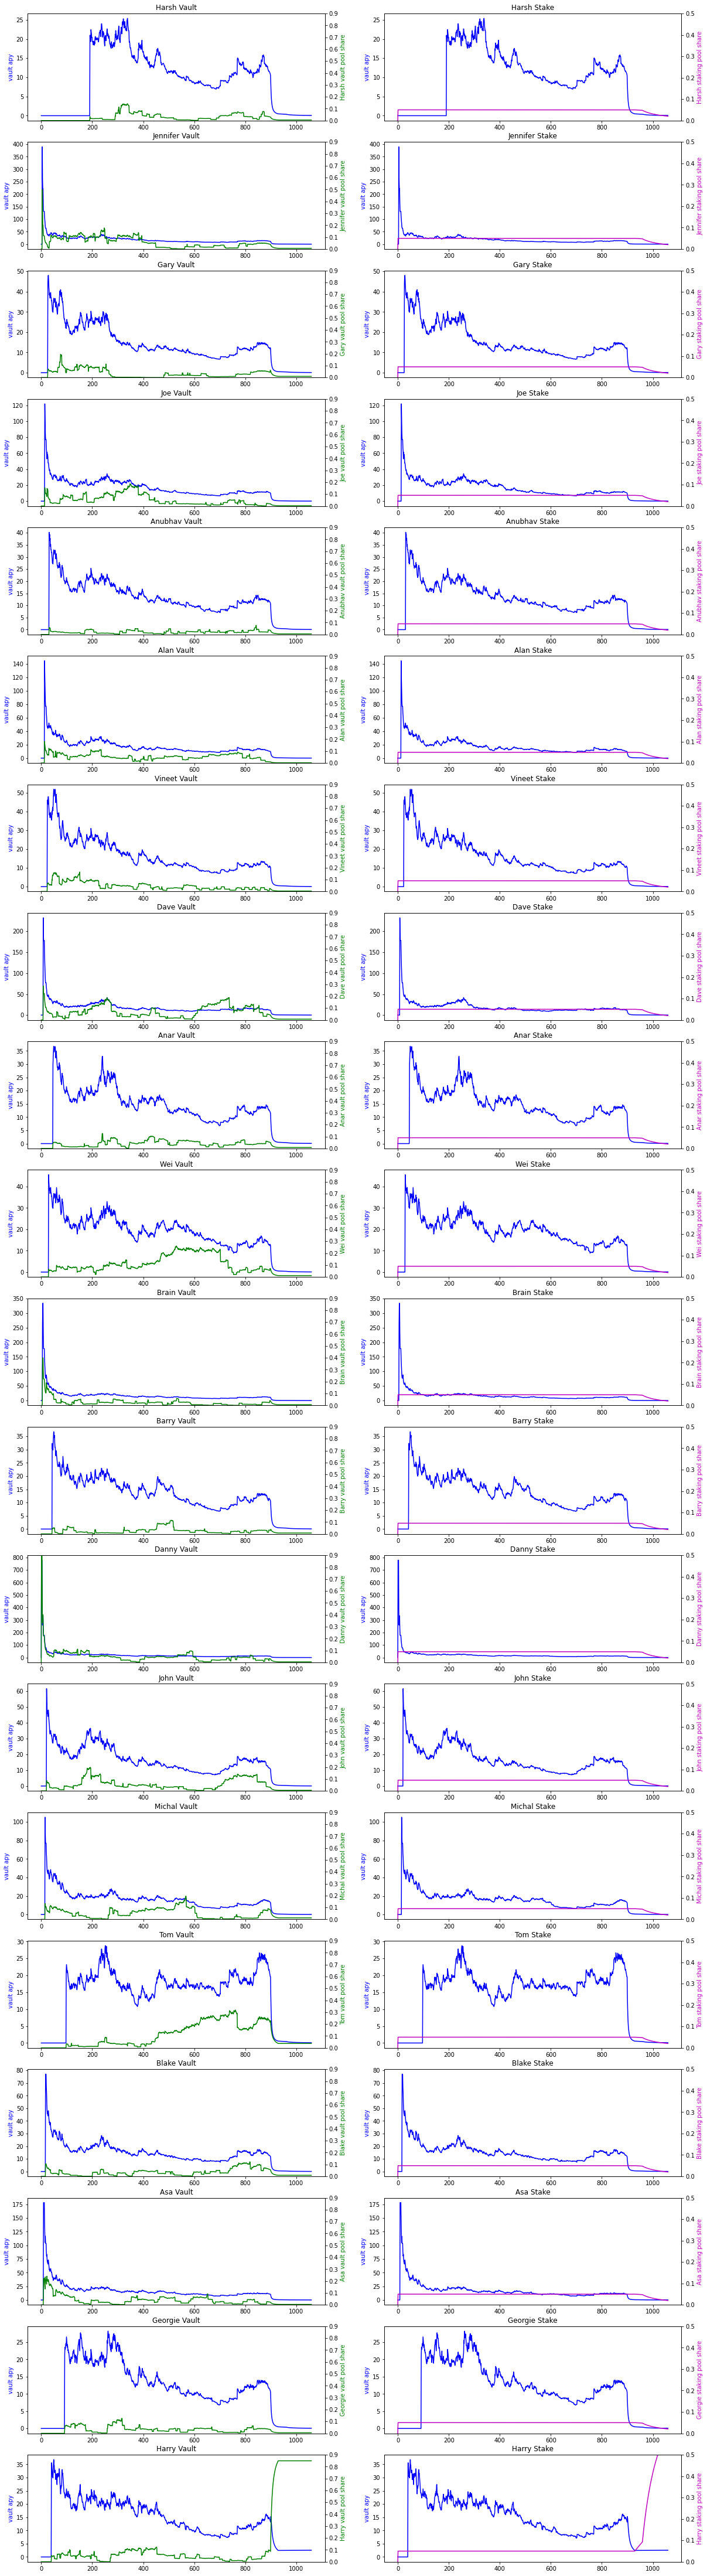

In [29]:
result = get_stats_per_tick(rewards, user_population)
plot_results(result, user_population)